#  Final Project -  Analyze the odds of approval based on various factors like income, credit history, etc. of a borrower applying for a loan


The purpose this project is to understand, based on given factors if it is possible to autoamte the process of a loan approval. I am using loan dataset obtained from kaggle.com. It has varous factors like education, gender, credit history that affects the odds of loan appproval.

* Author(s): [Mehfuz Hossain](mehfuz.hossain@du.edu)

* Github: [Tools 1 Final Project](https://github.com/duproject2020/du-tools1-final-project)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing

In [3]:
loan_data = 'loan_data.csv'

df = pd.read_csv(loan_data)

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.shape

(614, 13)

We have 614 rows and 13 columns in the dataset

In [5]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Here , we are interested in `Loan_Status` where 'Y' means approved and 'N' means rejected. 

Independent variables that can affect the `Loan_Status`:

* Gender
* Married
* Dependents
* Education
* Self_Employed
* Property_Area



In [6]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

There are null value columns which can cause problem to the loan approval prediction, we want to understand if any of these applicants are approved for a loan

In [7]:
missing_history = df[df['Credit_History'].isna()]
missing_history['Loan_Status'].value_counts()

Y    37
N    13
Name: Loan_Status, dtype: int64

We do see some applicants approved without a credit history, this could be first time loan applicatnts or self-employed

In [8]:
employed = df['Self_Employed'].value_counts().index[0]
self_employed = df['Self_Employed'].value_counts().index[1]


df.loc[(df['Self_Employed'] == self_employed) & (df['Credit_History'].isna()), 'Credit_History'] = 0.0
df.loc[(df['Self_Employed'] == employed) & (df['Credit_History'].isna()), 'Credit_History'] = 1.0

df.loc[(df['Credit_History'].isnull()) & (df['Loan_Status'] == 'Y'), 'Credit_History'] = 1.0

df['Credit_History'].fillna(0.0, inplace=True)

I have set the credit history to 0.0 for self-employed. For application who have a missing status for `self-employed`, I've used `loan_status` to determine if the person has a credit history, otherwise set 0.0 for all missing credit history

In [9]:
df.loc[(df['Self_Employed'].isnull()) & (df['Credit_History'] > 0.0), "Self_Employed"] = df['Self_Employed'].value_counts().index[0]
df.loc[(df['Self_Employed'].isnull()) & (df['Credit_History'] == 0.0), "Self_Employed"] = df['Self_Employed'].value_counts().index[1]

I've also set `Self-Employed` based on `Credit_History`. The borrowers who do not have a credit history are likely to be self-employed

In [10]:
df.loc[(df['Married'].isnull()) & (df['CoapplicantIncome'] > 0.0), "Married"] = df['Married'].value_counts().index[0]
df.loc[(df['Married'].isnull()) & (df['CoapplicantIncome'] == 0.0), "Married"] = df['Married'].value_counts().index[1]


Missing values for `Married` column, we are setting "yes" for entries with co-applicant income, otherwise "No" 

In [11]:
married = df['Married'].value_counts().index[0]

male = df['Gender'].value_counts().index[0]
female = df['Gender'].value_counts().index[1]

df.loc[(df['Gender'].isnull()) & (df['Married'] == married) & (df['ApplicantIncome'] > df['CoapplicantIncome']), 'Gender'] = male
df.loc[(df['Gender'].isnull()) & (df['Married'] == married) & (df['ApplicantIncome'] < df['CoapplicantIncome']), 'Gender'] = male

df['Gender'].fillna(female, inplace=True)

For married couples, I am assuming gender is male for higher income applicant or coapplicant (we are applying bias based on norm)

I am setting `Female` for the rest of the missing values

In [12]:
df['Dependents'].fillna(df['Dependents'].value_counts().index[0], inplace=True)


I am assuming for missing values, there are no dependents for the applicant.

In [13]:
df.loc[(df['LoanAmount'].isna()) & (df['Loan_Status'] == 'N'), 'LoanAmount'] = 0.0 
#rest
df['LoanAmount'].fillna( df['LoanAmount'].median(), inplace=True)

I have set the loan amount to zero for applicants whose loan is not approved, otherwise I've set the loan amount with median value.

In [14]:
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)

I am also setting the missing loan amount term based on the median value.

In [15]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Finally, I am verifying that data is clean and predictors do not have any null / missing values


In [16]:
dst_filename = "loan_data.pkl"
pd.to_pickle(df, dst_filename)


Saving the clean dataset to a pickle file for future processing

## Data Analysis (EDA)

In [17]:
# Loading the data
dst_filename = "loan_data.pkl"
loan_clean_df = pd.read_pickle(dst_filename)


In [18]:
loan_clean_df['Loan_Status'].value_counts(normalize=True, dropna=False)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

Based on above data, around 68% of the applicants are approved for a loan

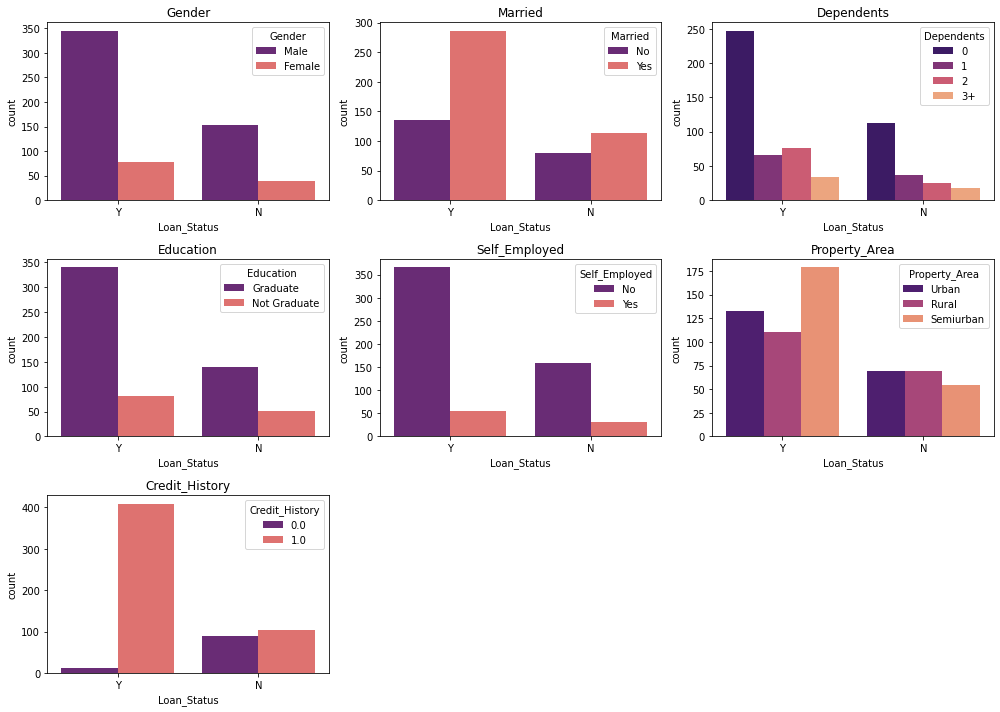

In [19]:
import math

categories = []

for col in loan_clean_df.columns:
    if loan_clean_df[col].dtype == 'object':
        categories.append(col)
        
# loan_id
categories.pop(0)
# loan_status
categories.pop(-1)
# include credit_history
categories.append('Credit_History')

cols = 3
rows = math.ceil(len(categories) / cols)

fig, axs = plt.subplots(rows, cols, figsize = (14, 10))

for i, ax in enumerate(axs.flat):
    if i < len(categories):
        sns.countplot(x='Loan_Status', hue=categories[i], data=loan_clean_df, ax=ax, palette='magma') 
        ax.set_title(categories[i])
        ax.set(ylabel='count')

               
axs[2, 2].set_axis_off()
axs[2, 1].set_axis_off()

plt.tight_layout()

plt.show()


After observating the categorial variables against `Loan_Status`, we can see the following patterns:

* Married applicatants vs single have more influence on `Loan_Status`
* Married and male appplicants have almost similar approval odds
* Approval odds are higher in graduate borrowers
* Self-employed applicants have lower approval rate
* Applicants with no kids have much higher approval rate
* Applicatiant's location or where he / she lives (`Property_Area`) is not very imporant when applying for a loan
* Appearently people with no credit history have almost no chance of getting approved for a loan

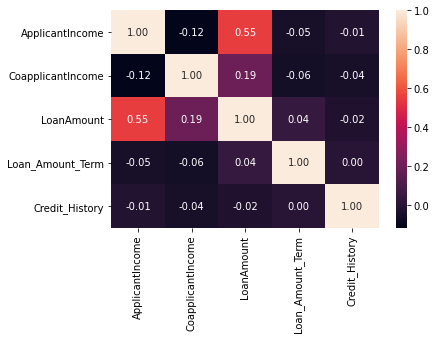

In [20]:
sns.heatmap(loan_clean_df.corr(), annot=True, fmt='.2f')
plt.show()

Doing a correlation analysis of the numerical field, we see the following liner relationship:

* `Loan_Amount`, `ApplcantIncome`
* `Loan_Amount`, `CoapplicantIncome`


Based on the above correlation, we can conclude that loan amount is higher for higher income borrowers. Therefore, if we consider married couples and combined income, the chances should be much higher


## Feature Engineering

In [21]:
loan_clean_df['TotalIncome']=  loan_clean_df['ApplicantIncome']+loan_clean_df['CoapplicantIncome']
loan_clean_df.sample()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
257,LP001854,Male,Yes,3+,Graduate,No,5250,0.0,94.0,360.0,1.0,Urban,N,5250.0


Based on the observation there is a positive relationship between the loan approval rate and the income, therefore the rate will be even higher with combined income.


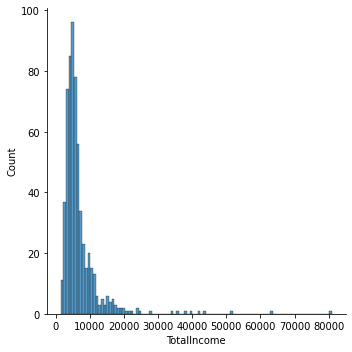

In [22]:
sns.displot(x='TotalIncome', data=loan_clean_df)

The data is shifted towards left, therefore it is right-skewed.

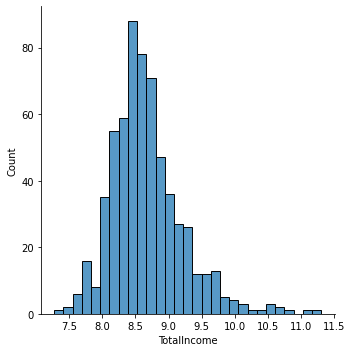

In [23]:
sns.displot(np.log(loan_clean_df['TotalIncome']))

Taking `np.log`, we can see that data is normally distributed and there are no major outliers that can affect our analysis

<AxesSubplot:>

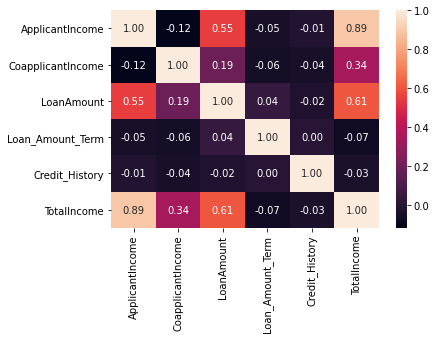

In [24]:
sns.heatmap(loan_clean_df.corr(), annot=True, fmt='.2f')

We can see from the heatmap that `TotalIncome` have most influence on `LoanAmount`.Now, based on `Loan_Amount_Term` and `LoanAmount` we can calculate the estimated monthy installment (EMI) of a borrower




In [25]:
loan_clean_df['EMI'] = (loan_clean_df['LoanAmount']) / (loan_clean_df['Loan_Amount_Term'])
loan_clean_df[loan_clean_df.Loan_Status == 'Y'].sample()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI
197,LP001669,Female,No,0,Not Graduate,No,1907,2365.0,120.0,360.0,1.0,Urban,Y,4272.0,0.333333


Now, substracting EMI from total income, we get the balance avaialble. The borrower is likey to get approved as the amount is higher

In [26]:
# loan amount in the dataset is calcuated in thosands.
loan_clean_df['Balance'] = (loan_clean_df['TotalIncome']) - (loan_clean_df['EMI'] * 1000) 

loan_clean_df.sample()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI,Balance
155,LP001536,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y,39999.0,3.333333,36665.666667


<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

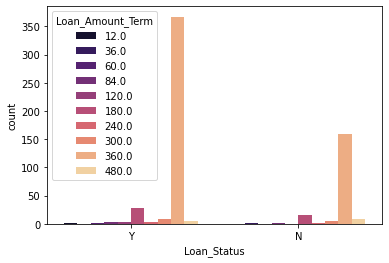

In [27]:
sns.countplot(x="Loan_Status", hue="Loan_Amount_Term", data=loan_clean_df, palette='magma')

We can see that there is a greater chance of approval for a longer loan term (30 yrs) loan. Based on Income and loan term, we can assume that a person will be approved for a loan, if he has high income and paying it off in longer terms. Lenders will feel much confident since the borrower has a wider room to pay back the loan.

Loan_Status
N    AxesSubplot(0.125,0.125;0.775x0.755)
Y    AxesSubplot(0.125,0.125;0.775x0.755)
Name: TotalIncome, dtype: object

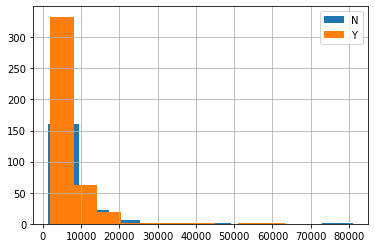

In [28]:
loan_clean_df.groupby('Loan_Status')['TotalIncome'].hist(legend=True)

Here, we can also see that odds of approval is much higher with income. 

Loan_Status
N    AxesSubplot(0.125,0.125;0.775x0.755)
Y    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Balance, dtype: object

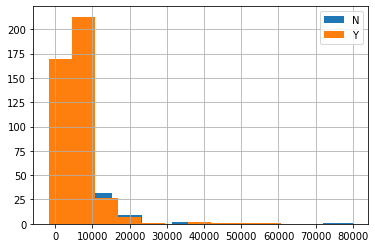

In [29]:
loan_clean_df.groupby('Loan_Status')['Balance'].hist(legend=True)

Similary, more balance after `EMI` increases the chance of apprroval

## Model Validation

In order to perform logistic regression, we first need to convert the categorical columns to numerical and remove the columns that do not have much effect on the target (based on our observation) or we have created new columns after performing featured engineering in the previous step

In [36]:
from sklearn.preprocessing import LabelEncoder

dat = loan_clean_df.drop(columns=['Loan_ID', 
                                  'Dependents', 
                                  'ApplicantIncome', 
                                  'CoapplicantIncome', 
                                  'Property_Area', 
                                  'EMI', 
                                  'Balance'])

encoder = LabelEncoder()

dat['Loan_Status'] = encoder.fit_transform(dat['Loan_Status'])
dat['Gender'] = encoder.fit_transform(dat['Gender'])
dat['Married'] = encoder.fit_transform(dat['Married'])
dat['Education'] = encoder.fit_transform(dat['Education'])
#dat['Dependents'] = encoder.fit_transform(dat['Dependents'])
dat['Self_Employed'] = encoder.fit_transform(dat['Self_Employed'])

dat.sample()


,Gender,Married,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome
17,0,0,0,0,76.0,360.0,0.0,0,3510.0


Next, we split the data into train / test sets and perform logistic regression

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Y = dat['Loan_Status']
X = dat.drop('Loan_Status', axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, Y_train)

Y_pred = logistic_model.predict(X_test)


Finally, we calcuate the f1 score of the model

In [38]:
from sklearn.metrics import f1_score

f1_score(Y_test, Y_pred)

0.8850174216027875

The model is almost 90% accurate

## Conclusion

We can conclude that there is a relation between loan approval odds vs borrower's income, credit history, loan term, education, marital and employment status. Based on the factors, we can predict if a borrower will be approved for a loan.